In [108]:
import tweepy
import pandas as pd
import datetime
import time
import csv
import warnings
warnings.filterwarnings("ignore")


# 1. Scrape Twitter data (Thai users) with hashtags about “covid-19”

In [ ]:
consumer_key = 
consumer_secret = 
access_token =
access_token_secret = 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


In [ ]:
# ฟังก์ชั่น เพื่อแก้ปัญหาเวลา request เยอะ หรือ session ครบ 15 นาที
def session_error(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.TweepError:
            time.sleep(16 * 60)
            continue
        except StopIteration:
            return

# ใช้ tweepy ดึงข้อมูล covid19 ภาษาไทย
i = 1
query = '#covid19'
dic= {'date': [], 'text': []}
tweets = tweepy.Cursor(api.search, q=query, since='2020-03-01', tweet_mode='extended', lang='th').items()

with open('covid19.csv', 'w', encoding='utf-8', newline='') as file:
    writer = csv.writer(file)
    for tweet in session_error(tweets):
        if tweet.full_text[:2]!='RT':
            print(i, tweet.created_at)
            writer.writerow([tweet.created_at, tweet.full_text.split('…')[0].split('https')[0]])
            i += 1 

# 2. Read in and preprocess text data

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pythainlp.tokenize import word_tokenize

In [2]:
# Import Data
df = pd.read_csv('covid19.csv', header=None, names=['Created at', 'Text'],  encoding='utf-8')
pd.set_option('display.max_colwidth', None)

In [3]:
df.head()

,Created at,Text
0,2020-04-29 06:16:39,Mask N95\nมาหร้อมแพคเกจจิงใหม่ ไฉไลกว่าเดิม💯💯💯\n✔️ป้องกันไวรัส\n✔️ป้องกันฝุ่นละออง\n✔️มีใบเซอร์\n✨ 69 บาท \n#หน้ากากอนามัย #หน้ากากอนามัยราคาถูก #หน้ากากอนามัยพร้อมส่ง #หน้ากากผ้า #แมสปิดปาก #ตลาดนัดออนไลน์ #โควิด_19 #โควิด19 #COVID19
1,2020-04-29 06:16:25,ชาวอเมริกันเกินครึ่ง เสื่อมศรัทธารัฐบาลทรัมป์ ปมแก้ปัญหาโควิด-19\n
2,2020-04-29 06:16:22,มติ กทม.เปิด 8 กิจการ ร้านอาหาร ตลาด ยกเว้นห้าง\n#โควิด19 #COVID19 #coronavirus #โควิด_19 #โควิท19 #NationTV \n#พรกฉุกเฉินฯ #เคอร์ฟิวทั่วประเทศ #อยู่บ้านหยุดเชื้อเพื่อชาติ\n
3,2020-04-29 06:16:21,สรุปสถานการณ์ COVID-19 ไทย 29 เม.ย.63\nอ่านต่อได้ที่ :
4,2020-04-29 06:15:24,"อย่าเพิ่งมา! ""อนุทิน"" วอนจีนงดเที่ยวไทยช่วงนี้ รอจนโควิดคลาย\n#โควิด19 #COVID19 #coronavirus #โควิด_19 #โควิท19 #NationTV \n"


In [4]:
# check duplicate & missing value
print('Duplicate =', sum(df.duplicated()))
print(df[df.duplicated()])
print('\n----------------------------------------------------------------------------------------------------------\n')
print('Missing values', sum(df['Text'].isnull()))
print(df[df['Text'].isnull()])

Duplicate = 12
               Created at  \
1131  2020-04-28 15:01:00   
2735  2020-04-28 04:12:54   
3163  2020-04-27 18:46:56   
3165  2020-04-27 18:46:55   
3171  2020-04-27 18:33:07   
3172  2020-04-27 18:33:07   
3186  2020-04-27 18:02:42   
3187  2020-04-27 18:02:42   
3192  2020-04-27 17:58:26   
3219  2020-04-27 17:23:49   
3220  2020-04-27 17:23:49   
3221  2020-04-27 17:23:49   

                                                                                                                                                                                                                               Text  
1131                                                             ⁣💙 ภาพการช่วยเหลือผู้ลี้ภัยในค่ายผู้ลี้ภัยประเทศแทนซาเนียค่ะ⠀\n⠀\n📌 ผู้ลี้ภัยทั่วโลกอีกจำนวนมากโดยเฉพาะผู้สูงอายุที่กำลังต้องการความช่วยเหลือ ร่วมบริจาคตอนนี้ ⠀\n  
2735  จากการดื่มปัสสาวะ ไปสู่การวางหัวหอมรอบบ้าน และกินแมวดำช่วยป้องกันโควิด-19 วิธีการสุดโต่งเหล่านี้ถูกส่งต่อ แต่ไม่มีรายงานทางวิทยาศาสตร์รับรอง 

In [5]:
# remove and check duplicate, missing value again
df.drop_duplicates(keep='first', inplace=True)
df.dropna(axis=0, inplace=True)
print('Duplicate =', sum(df.duplicated()))
print('Missing values', sum(df['Text'].isnull()))
df.reset_index(drop=True, inplace=True)

Duplicate = 0
Missing values 0


In [6]:
# Regex remove emoticon, remove some symbol, stem word covid

# emoji, emoticon
emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0000260E"             # telephone 
                            u"\U0001F92D"             # smile emoticon
                            u"\U0001F914"             # thinking emoticon
                                               "]+", flags=re.UNICODE)

# mention & hashtag
tag_pattern = r"[#@]([^\s]+)"

# symbol, some number
remove_pattern = r"\u200b|\n|#|[^(N95|n95)](\d+)|-|\.|,|:|;|\"|'|\(|\)|_|%|&|!|\+|//|[ ]{2,}|\?|\/|“|”|฿"

# covid form
covid_pattern = r"โควิด|โควิท|covid|Covid|COVID"

# repeat character
repeat_pattern = r"([ก-ฮ])([ก-ฮ]*\1){2,}"

# single character 
single_char_pattern = r" (.) "

# month pattern
month_pattern = r"เมย|มีค|พค"



df['Text'].replace(emoji_pattern ,'', regex=True, inplace=True) # remove emoji emoticon
df['Text'].replace(tag_pattern, '', regex=True, inplace=True) # remove tag & mention  (@sss #ddd)
df['Text'].replace(remove_pattern, '', regex=True, inplace=True) # remove symbol
df['Text'].replace(single_char_pattern, ' ', regex=True, inplace=True) # กระทบจากการตัดก่อนหน้า เช่น เวลา 9.00 น. -> เวลา น
df['Text'].replace(repeat_pattern, '\\1', regex=True, inplace=True) # จะไปหนายยยย
df['Text'].replace(month_pattern, '', regex=True, inplace=True) 
df['Text'].replace(covid_pattern, 'covid', regex=True, inplace=True) # เปลี่ยนให้อยู่ form เดียวกัน 




# 3. Calculate a LDA topic model (k = 10) 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from pythainlp.corpus import thai_stopwords

In [8]:
stopwords = thai_stopwords()

In [9]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.7, min_df=70, stop_words = stopwords, tokenizer=lambda text: word_tokenize(text, engine='utmfit', keep_whitespace=False))

# apply transformation
tf = vectorizer.fit_transform(df['Text']) 

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
tf.shape 

C:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กระไร', 'กาลนาน', 'ชิ้น', 'ดังที่', 'ดี', 'ดีกว่า', 'ด้อย', 'ตัว', 'ต่อไป', 'ถัดไป', 'ทั่วถึง', 'ทำ', 'ที่จะ', 'ท่าน', 'ท้าย', 'นา', 'บอ', 'บัด', 'ระยะเวลา', 'ล่ะ', 'วันวาน', 'สม', 'สมบูรณ์', 'สํา', 'หน้า', 'หรับ', 'หา', 'อย', 'เกี่ยว', 'เก่า', 'เดี๋ยวนี้', 'เย็น', 'เล่า', 'เสมือน', 'เหมือนกัน', 'แด่', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(6101, 172)

In [10]:
# Model LDA for Topci modeling
from sklearn.decomposition import LatentDirichletAllocation

# Define number of topic and top word 
number_of_topics = 10
number_words = 10
LDA = LatentDirichletAllocation(n_components=number_of_topics, random_state=10) # random state for reproducibility

# Fit data to model
LDA.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=10, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [11]:
# เช็คจำนวนผลลัพธืหลัง fit 
print('จำนวน word', len(vectorizer.get_feature_names()))
print('จำนวน topic', len(LDA.components_))
print('จำนวน compoent ใน topic', len(LDA.components_[0]))

จำนวน word 172
จำนวน topic 10
จำนวน compoent ใน topic 172


10 topic , component 12 word ตาม เกณฑ์ min 70 max 70%

In [12]:
# เช็ค word 
vectorizer.get_feature_names()

['1',
 '2',
 '[',
 'covid',
 'dm',
 'live',
 'ก',
 'กทม',
 'กรอง',
 'กลับบ้าน',
 'กลับมา',
 'กักตัว',
 'กิน',
 'ขนาด',
 'ขอให้',
 'ขาย',
 'ข่าว',
 'ข้อมูล',
 'คน',
 'คนไทย',
 'ครม',
 'คลาย',
 'ควบคุม',
 'คัด',
 'ค่า',
 'งาน',
 'จ',
 'จังหวัด',
 'จำนวน',
 'จีน',
 'จ่าย',
 'ฉุกเฉิน',
 'ชม',
 'ชิ้น',
 'ชีวิต',
 'ชี้',
 'ชุด',
 'ช่วยเหลือ',
 'ซื้อ',
 'ดาวน์',
 'ดี',
 'ดู',
 'ดูแล',
 'ด่วน',
 'ต',
 'ตรวจ',
 'ตอนนี้',
 'ตัว',
 'ตัวเลข',
 'ตัวเอง',
 'ตาย',
 'ติด',
 'ติดตาม',
 'ติดเชื้อ',
 'ต่อไป',
 'ทวี',
 'ทัก',
 'ทั่วโลก',
 'ทำ',
 'ทำงาน',
 'ธุรกิจ',
 'น',
 'นพ',
 'นะคะ',
 'นายกฯ',
 'น้า',
 'บริการ',
 'บาท',
 'บ้าน',
 'ประกาศ',
 'ประจำ',
 'ประชาชน',
 'ประเทศ',
 'ปลอดภัย',
 'ปี',
 'ป่วย',
 'ป้องกัน',
 'ผลกระทบ',
 'ผู้ป่วย',
 'ผู้เสียชีวิต',
 'ผ่อนปรน',
 'พร',
 'พัน',
 'พื้นที่',
 'ฟรี',
 'ม',
 'มาตรการ',
 'ยอด',
 'รพ',
 'รอ',
 'รอบ',
 'ระบาด',
 'รักษา',
 'รัฐ',
 'รัฐบาล',
 'ราคา',
 'รายงาน',
 'รี',
 'รู้',
 'ล',
 'ลด',
 'ล็อก',
 'ล้างมือ',
 'ล้าน',
 'วันที่',
 'วันหยุด',
 'วิ',
 'วิกฤต',
 'ว

# 4. Visualize the results from the calculated model

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# set font for thai alplhabet when plot graph 
sns.set(font='tahoma')

## Typical display of topics

In [14]:
# Define list and dict for create top word dataframe for each topic 
topic_list = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']
topic_dict = {}
word = vectorizer.get_feature_names()

# list top word in each topic and append to dict 
for index, topic in enumerate(LDA.components_):
    topic_dict[str(topic_list[index])] = []
    for i in topic.argsort()[:-number_words - 1:-1]:
        topic_dict[str(topic_list[index])].append(word[i])

# Create Dataframe from top word dict 
topic_df = pd.DataFrame.from_dict(topic_dict)
topic_df
    

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,บาท,covid,covid,ติดเชื้อ,ผู้ป่วย,คน,ล้าน,เดือน,ตรวจ,บ้าน
1,นะคะ,ป้องกัน,สถานการณ์,เสียชีวิต,ชม,ติดเชื้อ,เงิน,ก,ข้อมูล,covid
2,ราคา,ประชาชน,วันที่,สะสม,เวลา,จำนวน,covid,พร,เรื่อง,ทำ
3,ค่า,มาตรการ,เมษายน,ยอด,ศูนย์,ผู้ป่วย,อ่าน,ฉุกเฉิน,ไทย,หยุด
4,ชิ้น,ลด,ติด,หาย,สถานการณ์,ล้าน,ไทย,เลื่อน,กักตัว,อย่า
5,ขาย,โรค,ไวรัส,รักษา,covid,ประเทศ,จีน,วันหยุด,คนไทย,ทำงาน
6,สนใจ,ล็อก,ไทย,ผู้ป่วย,เสี่ยง,ทั่วโลก,บาท,ศบค,เมือง,หมอ
7,ฟรี,เผย,เชื้อไวรัส,covid,แถลง,ไทย,เยียวยา,ประกาศ,covid,เชื้อ
8,dm,ดาวน์,ประจำ,ผู้เสียชีวิต,live,ทวี,ดู,รอ,ประเทศ,’
9,หน้ากาก,เตรียม,ในประเทศ,ไทย,สด,ศิลป์,ข่าว,ครม,แจก,กลับมา


จากผลลัพธ์จะเห็นได้ว่า หัวข้อจะมีเนื้อหาประมาณนี้  
topic 1 = ขายหน้ากาก  
topic 2 = มาตรการล็อคดาวน์  
topic 3 = สถานการณ์ คนติดเชื้อ  
topic 4 = ยอดผู้ป่วย ผู้ตาย รักษา  
topic 5 = แถลง live  
topic 6 = ข่าวทั่วโลก?  
topic 7 = การเยียวยา อัดฉีด  
topic 8 = รัฐบาล  
topic 9 = การตรวจ การแจกเงิน  
topic 10 = Work from home  

In [15]:
# Define topic name 
topic_name = ['หน้ากาก', 'lockdown', 'สถานการณ์', 'ยอดผู้ป่วย', 'แถลงlive', 'ข่าวโลก', 'การเยียวยา', 'รัฐบาล' ,'การตรวจ', 'WFH']

## Topic distribution 

In [16]:
# Transfrom scipy matrix to dataframe 
count_tf = pd.DataFrame(tf.todense(), columns=vectorizer.get_feature_names())
count_tf

,1,2,[,covid,dm,live,ก,กทม,กรอง,กลับบ้าน,...,โรค,โรงพยาบาล,โลก,ในประเทศ,ใส่,ไทย,ไวรัส,์,‘,’
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6096,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
6097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Check shame before dot matrix
print('count word 6101 tweet 172 word', count_tf.shape)
print()
topic_component = pd.DataFrame(LDA.components_)
print('topic_component 10 topic 172 word', topic_component.shape)

count word 6101 tweet 172 word (6101, 172)

topic_component 10 topic 172 word (10, 172)


In [18]:
# change columns to feature word 
topic_component.columns = vectorizer.get_feature_names()
topic_component

,1,2,[,covid,dm,live,ก,กทม,กรอง,กลับบ้าน,...,โรค,โรงพยาบาล,โลก,ในประเทศ,ใส่,ไทย,ไวรัส,์,‘,’
0,81.064963,33.089132,12.712502,0.100019,148.099993,0.100000,0.100005,0.100003,50.590351,0.100002,...,0.100003,0.100005,0.100005,0.100002,123.751868,0.100008,11.403715,0.100008,0.100001,0.100001
1,0.100005,3.298991,0.100008,474.151829,0.100000,0.100005,0.100007,86.492731,61.609619,0.100003,...,156.348729,30.331823,19.509837,0.100013,11.446888,0.105817,42.790852,84.964352,0.100005,0.100004
2,0.100012,4.116458,0.100014,451.405800,0.100000,0.100003,0.100001,0.100002,0.100001,0.100006,...,58.238759,0.100006,0.100016,97.359905,0.100003,127.330706,129.105390,0.100011,0.100001,0.100002
3,15.567778,22.763370,0.100017,249.653108,0.100000,0.100001,0.100001,0.100324,0.100001,55.267670,...,1.369419,24.167512,24.306113,0.100024,0.100004,154.393125,0.100006,0.100003,0.100002,0.100002
4,0.144031,3.365547,59.487436,87.980739,0.100000,76.099972,0.100005,24.028460,0.100005,72.531944,...,0.280340,71.679250,0.105544,22.823506,0.100014,74.328334,0.100013,0.117927,0.100003,0.100002
5,10.086596,3.966420,0.100003,34.786021,0.100000,0.100003,0.100001,8.404654,0.100003,0.227707,...,6.503965,1.221386,29.814552,1.802962,0.100005,53.338933,0.100006,0.100003,0.100003,0.100003
6,0.100022,0.100037,0.100003,181.044344,0.100001,0.100002,0.100003,0.100002,0.100005,0.100003,...,0.100011,0.100004,0.100020,0.100007,0.100005,150.612286,0.100005,0.217670,0.100005,0.100008
7,7.636571,0.100030,0.100008,9.436027,0.100000,0.100003,217.099964,5.473811,0.100001,0.100006,...,0.100055,0.100003,0.100847,0.100011,0.100001,0.100019,0.100006,0.100005,0.100002,0.100002
8,0.100008,0.100007,0.100005,95.671357,0.100002,0.100006,0.100005,0.100006,0.100011,0.372653,...,21.856487,0.100008,0.100013,1.413561,0.100012,132.590756,0.100003,0.100009,0.100001,0.100002
9,0.100014,0.100008,0.100002,197.770756,0.100002,0.100004,0.100008,0.100007,0.100004,0.100007,...,0.102232,0.100005,54.763052,0.100009,0.101200,0.100016,0.100004,0.100013,93.099977,101.099975


In [19]:
# Dot Matrix
count_tf_transpose = count_tf.transpose()
count_tf_transpose.shape
topic_distribution = topic_component.dot(count_tf_transpose)
topic_distribution

,0,1,2,3,4,5,6,7,8,9,...,6091,6092,6093,6094,6095,6096,6097,6098,6099,6100
0,538.561439,0.200021,0.100003,0.500036,34.751349,214.198477,0.500013,0.100002,0.900015,50.925431,...,1519.500353,0.200021,81.064963,0.307823,0.707856,1.100020,28.020352,0.231301,4.216996,0.200019
1,477.915654,538.941548,86.492731,540.577655,563.723381,0.200004,359.545140,0.100004,0.900050,476.198124,...,38.233151,572.123452,0.100005,558.316287,643.598090,1.105864,33.652566,0.720446,88.035675,474.251833
2,151.664560,451.505812,0.100002,963.269762,588.233407,0.200006,32.082322,46.004561,793.199680,508.976822,...,42.812888,451.505805,0.100012,451.505805,833.597933,134.022918,32.802778,0.200009,44.274779,451.505812
3,0.400011,249.753111,0.100324,508.260299,404.838633,0.200002,0.500038,0.100002,2276.087336,249.953122,...,35.076986,249.753111,15.567778,249.753114,713.032492,2897.309346,0.200014,0.200021,13.281872,295.434397
4,0.400025,88.080755,24.028460,253.101933,162.709108,0.200010,0.500057,0.100009,846.245728,108.918743,...,3.405607,88.080745,0.144031,88.080748,311.183678,626.854035,23.186186,0.200013,237.699137,170.697416
5,0.400016,34.886029,8.404654,123.818154,102.803417,0.200006,1294.503006,0.100012,342.171671,63.347379,...,20.773216,34.886029,10.086596,35.480622,195.597423,289.086414,0.440021,1294.199710,20.821652,34.886033
6,133.527809,194.276229,0.100002,504.714183,528.097032,0.201476,277.239236,37.188718,0.903657,181.344382,...,133.932959,217.846216,0.100022,181.144359,633.198886,151.612318,0.200012,0.200240,1.105476,181.144345
7,0.404960,23.486871,5.473811,45.079134,115.069272,140.199987,108.106388,0.106661,1.703433,81.839582,...,15.883076,20.309013,7.636571,9.536032,9.936095,134.945570,0.200074,0.200013,109.436726,15.238028
8,0.400034,133.554564,0.100006,243.377822,230.870886,0.200015,41.401141,0.100011,15.988379,179.529254,...,34.800615,96.153713,0.100008,95.771365,493.643641,133.863449,0.200563,0.973174,589.611976,95.771359
9,1.325492,220.315060,0.100007,220.301021,315.903515,0.200017,31.622658,0.100020,0.900052,230.967160,...,94.581151,198.141894,0.100014,231.103844,231.503906,1.100065,104.097434,356.875072,466.515711,197.870759


In [20]:
# sum distribution for topic
topic_distribution['sum'] = topic_distribution.sum(axis=1)
topic_distribution

,0,1,2,3,4,5,6,7,8,9,...,6092,6093,6094,6095,6096,6097,6098,6099,6100,sum
0,538.561439,0.200021,0.100003,0.500036,34.751349,214.198477,0.500013,0.100002,0.900015,50.925431,...,0.200021,81.064963,0.307823,0.707856,1.100020,28.020352,0.231301,4.216996,0.200019,1.154402e+06
1,477.915654,538.941548,86.492731,540.577655,563.723381,0.200004,359.545140,0.100004,0.900050,476.198124,...,572.123452,0.100005,558.316287,643.598090,1.105864,33.652566,0.720446,88.035675,474.251833,1.357512e+06
2,151.664560,451.505812,0.100002,963.269762,588.233407,0.200006,32.082322,46.004561,793.199680,508.976822,...,451.505805,0.100012,451.505805,833.597933,134.022918,32.802778,0.200009,44.274779,451.505812,1.498243e+06
3,0.400011,249.753111,0.100324,508.260299,404.838633,0.200002,0.500038,0.100002,2276.087336,249.953122,...,249.753111,15.567778,249.753114,713.032492,2897.309346,0.200014,0.200021,13.281872,295.434397,2.216068e+06
4,0.400025,88.080755,24.028460,253.101933,162.709108,0.200010,0.500057,0.100009,846.245728,108.918743,...,88.080745,0.144031,88.080748,311.183678,626.854035,23.186186,0.200013,237.699137,170.697416,6.670247e+05
5,0.400016,34.886029,8.404654,123.818154,102.803417,0.200006,1294.503006,0.100012,342.171671,63.347379,...,34.886029,10.086596,35.480622,195.597423,289.086414,0.440021,1294.199710,20.821652,34.886033,2.078410e+06
6,133.527809,194.276229,0.100002,504.714183,528.097032,0.201476,277.239236,37.188718,0.903657,181.344382,...,217.846216,0.100022,181.144359,633.198886,151.612318,0.200012,0.200240,1.105476,181.144345,9.201817e+05
7,0.404960,23.486871,5.473811,45.079134,115.069272,140.199987,108.106388,0.106661,1.703433,81.839582,...,20.309013,7.636571,9.536032,9.936095,134.945570,0.200074,0.200013,109.436726,15.238028,4.902067e+05
8,0.400034,133.554564,0.100006,243.377822,230.870886,0.200015,41.401141,0.100011,15.988379,179.529254,...,96.153713,0.100008,95.771365,493.643641,133.863449,0.200563,0.973174,589.611976,95.771359,5.648601e+05
9,1.325492,220.315060,0.100007,220.301021,315.903515,0.200017,31.622658,0.100020,0.900052,230.967160,...,198.141894,0.100014,231.103844,231.503906,1.100065,104.097434,356.875072,466.515711,197.870759,7.700860e+05


In [21]:
# Change index to topic name
topic_distribution.index = topic_name
topic_distribution

,0,1,2,3,4,5,6,7,8,9,...,6092,6093,6094,6095,6096,6097,6098,6099,6100,sum
หน้ากาก,538.561439,0.200021,0.100003,0.500036,34.751349,214.198477,0.500013,0.100002,0.900015,50.925431,...,0.200021,81.064963,0.307823,0.707856,1.100020,28.020352,0.231301,4.216996,0.200019,1.154402e+06
lockdown,477.915654,538.941548,86.492731,540.577655,563.723381,0.200004,359.545140,0.100004,0.900050,476.198124,...,572.123452,0.100005,558.316287,643.598090,1.105864,33.652566,0.720446,88.035675,474.251833,1.357512e+06
สถานการณ์,151.664560,451.505812,0.100002,963.269762,588.233407,0.200006,32.082322,46.004561,793.199680,508.976822,...,451.505805,0.100012,451.505805,833.597933,134.022918,32.802778,0.200009,44.274779,451.505812,1.498243e+06
ยอดผู้ป่วย,0.400011,249.753111,0.100324,508.260299,404.838633,0.200002,0.500038,0.100002,2276.087336,249.953122,...,249.753111,15.567778,249.753114,713.032492,2897.309346,0.200014,0.200021,13.281872,295.434397,2.216068e+06
แถลงlive,0.400025,88.080755,24.028460,253.101933,162.709108,0.200010,0.500057,0.100009,846.245728,108.918743,...,88.080745,0.144031,88.080748,311.183678,626.854035,23.186186,0.200013,237.699137,170.697416,6.670247e+05
ข่าวโลก,0.400016,34.886029,8.404654,123.818154,102.803417,0.200006,1294.503006,0.100012,342.171671,63.347379,...,34.886029,10.086596,35.480622,195.597423,289.086414,0.440021,1294.199710,20.821652,34.886033,2.078410e+06
การเยียวยา,133.527809,194.276229,0.100002,504.714183,528.097032,0.201476,277.239236,37.188718,0.903657,181.344382,...,217.846216,0.100022,181.144359,633.198886,151.612318,0.200012,0.200240,1.105476,181.144345,9.201817e+05
รัฐบาล,0.404960,23.486871,5.473811,45.079134,115.069272,140.199987,108.106388,0.106661,1.703433,81.839582,...,20.309013,7.636571,9.536032,9.936095,134.945570,0.200074,0.200013,109.436726,15.238028,4.902067e+05
การตรวจ,0.400034,133.554564,0.100006,243.377822,230.870886,0.200015,41.401141,0.100011,15.988379,179.529254,...,96.153713,0.100008,95.771365,493.643641,133.863449,0.200563,0.973174,589.611976,95.771359,5.648601e+05
WFH,1.325492,220.315060,0.100007,220.301021,315.903515,0.200017,31.622658,0.100020,0.900052,230.967160,...,198.141894,0.100014,231.103844,231.503906,1.100065,104.097434,356.875072,466.515711,197.870759,7.700860e+05


In [22]:
# Normalized to 1
topic_distribution['normalized'] = topic_distribution['sum'] / topic_distribution['sum'].sum(axis=0)

Text(0.5, 0, 'Distribution percentage')

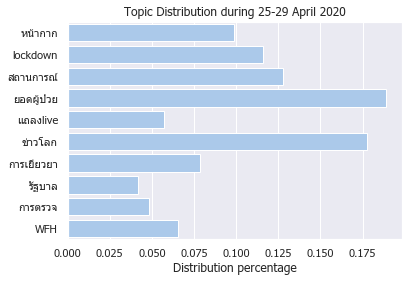

In [39]:
# plot topic distribution
sns.set_color_codes("pastel")
sns.barplot(topic_distribution['normalized'], y=topic_distribution.index, color="b")
plt.title('Topic Distribution during 25-29 April 2020')
plt.xlabel('Distribution percentage')

## Display a topic as a word cloud

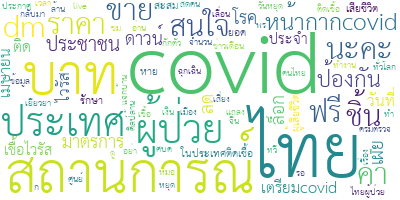

In [24]:
# Display a topic as a word cloud

# Concatenate top 10 word to 1 string
all_topic_word = ""
for index, topic in enumerate(LDA.components_):
    all_topic_word += " ".join([word[i]
                        for i in topic.argsort()[:-number_words - 1:-1]])
    
    
# path ของ font
path = 'THSarabunNew.ttf'

# regex for thai font in Word Cloud 
regexp = r"[ก-๙a-zA-Z']+"

# Create a WordCloud object
wordcloud = WordCloud(font_path=path, background_color="white", max_words=5000, 
                      contour_width=3, contour_color='steelblue', regexp=r"[\u0E00-\u0E7Fa-zA-Z']+")
# Generate a word cloud
wordcloud.generate(all_topic_word)
# Visualize the word cloud
wordcloud.to_image()

## Topic proportions over time

In [25]:
# extract date
df2 = df.copy()
df2['Created at'] = pd.to_datetime(df2['Created at'], format="%Y-%m-%d")
df2['day'] = df2['Created at'].dt.day


In [26]:
df2.head()

,Created at,Text,day
0,2020-04-29 06:16:39,Mask N95มาหร้อมแเกจจิงใหม่ ไฉไลกว่าเดิมป้องกันไวรัสป้องกันฝุ่นละอองมีใบเซอร์ บาท,29
1,2020-04-29 06:16:25,ชาวอเมริกันเกินครึ่ง เสื่อมศรัทธารัฐบาลทรัมป์ ปมแก้ปัญหาcovid,29
2,2020-04-29 06:16:22,มติ กทมเปิด กิจการ ร้านอาหาร ตลาด ยกเว้นห้าง,29
3,2020-04-29 06:16:21,สรุปสถานการณ์ covid ไทย อ่านต่อได้ที่,29
4,2020-04-29 06:15:24,อย่าเพิ่งมา อนุทิน วอนจีนงดเที่ยวไทยช่วงนี้ รอจนcovidคลาย,29


In [27]:
# Transpose for add day feature in next step
topic_distribution_transpose = topic_distribution.transpose()
topic_distribution_transpose.head()

,หน้ากาก,lockdown,สถานการณ์,ยอดผู้ป่วย,แถลงlive,ข่าวโลก,การเยียวยา,รัฐบาล,การตรวจ,WFH
0,538.561439,477.915654,151.664560,0.400011,0.400025,0.400016,133.527809,0.404960,0.400034,1.325492
1,0.200021,538.941548,451.505812,249.753111,88.080755,34.886029,194.276229,23.486871,133.554564,220.315060
2,0.100003,86.492731,0.100002,0.100324,24.028460,8.404654,0.100002,5.473811,0.100006,0.100007
3,0.500036,540.577655,963.269762,508.260299,253.101933,123.818154,504.714183,45.079134,243.377822,220.301021
4,34.751349,563.723381,588.233407,404.838633,162.709108,102.803417,528.097032,115.069272,230.870886,315.903515


In [28]:
# drop unused index and add day feature
topic_distribution_transpose.drop(['sum', 'normalized'], axis=0, inplace=True)
topic_distribution_transpose['day'] = df2['day']
topic_distribution_transpose.head()

,หน้ากาก,lockdown,สถานการณ์,ยอดผู้ป่วย,แถลงlive,ข่าวโลก,การเยียวยา,รัฐบาล,การตรวจ,WFH,day
0,538.561439,477.915654,151.664560,0.400011,0.400025,0.400016,133.527809,0.404960,0.400034,1.325492,29
1,0.200021,538.941548,451.505812,249.753111,88.080755,34.886029,194.276229,23.486871,133.554564,220.315060,29
2,0.100003,86.492731,0.100002,0.100324,24.028460,8.404654,0.100002,5.473811,0.100006,0.100007,29
3,0.500036,540.577655,963.269762,508.260299,253.101933,123.818154,504.714183,45.079134,243.377822,220.301021,29
4,34.751349,563.723381,588.233407,404.838633,162.709108,102.803417,528.097032,115.069272,230.870886,315.903515,29


In [29]:
# Group by day
df_date = topic_distribution_transpose.groupby(['day']).sum()
df_date

,หน้ากาก,lockdown,สถานการณ์,ยอดผู้ป่วย,แถลงlive,ข่าวโลก,การเยียวยา,รัฐบาล,การตรวจ,WFH
day,,,,,,,,,,
25,75080.846685,93128.432966,89077.359925,112515.871599,33093.713303,116733.730925,54657.314526,14663.585971,36141.812194,51145.331906
26,190130.368411,228655.522649,259731.978032,402816.885325,116250.061246,363680.516076,140389.248572,46775.826134,100479.921073,127818.672482
27,254521.723975,406333.085697,439058.761529,648472.247718,197942.362896,564915.399099,256255.345534,187865.046418,162705.300563,219240.726572
28,405057.230603,425131.301028,475429.427852,682138.476496,207835.375830,710493.077593,323098.528039,181305.325756,183160.278217,261187.978586
29,229611.798328,204263.281010,234945.512733,370124.189518,111903.172874,322587.739155,145781.299492,59596.923207,82372.791803,110693.291880


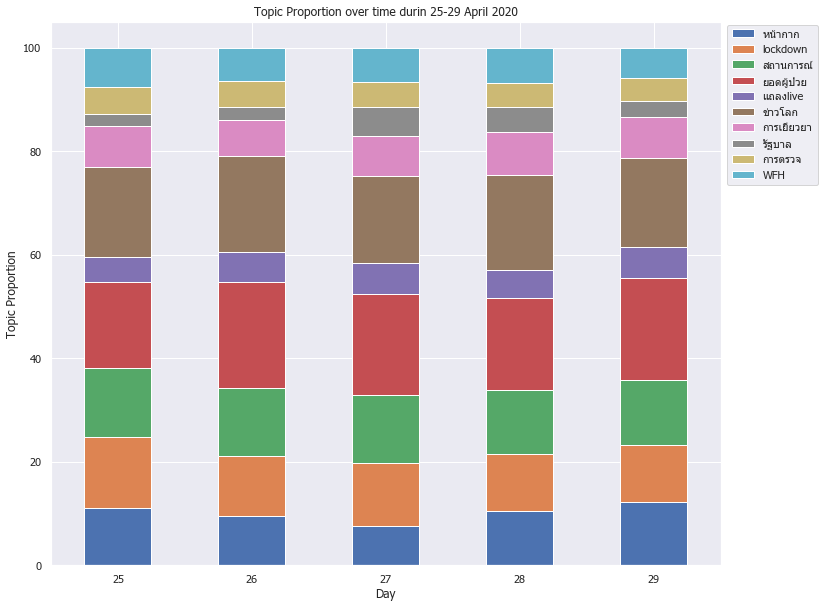

In [43]:
# Plot percentage stacked bar chart 
stacked_data = df_date.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, figsize=(12,10))
plt.title("Topic Proportion over time durin 25-29 April 2020")
plt.xlabel("Day")
plt.xticks(rotation=0)
plt.ylabel("Topic Proportion") 
plt.legend(loc=(1.01,0.70))  # legend outside plot